# GIS GZ – Übung 10: Datenanalyse I <span style="color:red">(Musterlösung)</span>

### Grobziele
* Sie können die Effekte unterschiedlicher Interpolationsmethoden wissenschaftlich untersuchen. 

### Feinziele
* Sie können die Funktionsweisen der Kernel Density Estimation (KDE) und Inverse Distance Weighting (IDW) erklären und ihre Unterschiede beschreiben. 
* Sie können Kernel Density Estimation (KDE) und Inverse Distance Weighting (IDW) implementieren. 
* Sie können wissenschaftlich untersuchen, wie sich die Resultate durch das Ändern der Eingangsparameter ändern. 

### Projekt
* Sie arbeiten an Ihrem Projekt und fokussieren auf die Datenanalyse. 

## Einleitung
In der heutigen Übung betrachten wir die Methoden *Kernel Density Estimation (KDE)* und *Inverse Distance Weighting (IDW)*. Während Erstere ein Verfahren zur Schätzung der Wahrscheinlichkeitsverteilung einer Zufallsvariablen ist, ist Letzere eine in der GIS-Welt häufig angewandte Interpolationsmethode, um Werte zwischen bekannten Messwerten zu interpolieren. Es geht wie häufig in der Welt hauptsächlich um das erste geographische Gesetz nach Waldo Tobler:  
> Everything is related to everything else, but near things are more related than distant things.
>
> -- <cite>Tobler W., (1970) "A computer movie simulating urban growth in the Detroit region". Economic Geography, 46(Supplement): 234–240.</cite>

Angenommen, es existiert ein räumliches Phänomen, aber Sie sind (aus wirtschaftlichen oder sonstigen Gründen) nur imstande, einige Punkte zu messen und daher eine Stichprobe zu nehmen, so müssen Sie die dazwischenliegenden Werte interpolieren. Das Ziel der heutigen Übung ist es, beide Verfahren selbstständig zu implementieren. Dabei sollen Sie auch unterschiedliche Kernels anwenden und deren Auswirkungen auf die resultierenden Karten untersuchen. 

### Dateien
Wir verwenden für diese Aufgabe den *Meuse*-Datensatz (siehe http://spatial-analyst.net/book/meusegrids), der von Burrough und McDonnel 1998 erstellt wurde. Der Datensatz umfasst vier Schwermetalle im Oberboden (Einheit: **ppm**) und andere Kovariaten, die entlang des Flusses *Meuse* in der oberen Bodenschicht gemessen wurde. Es scheint so, als ob der Fluss die mit Schwermetall belasteten Sedimente flussabwärts transportieren und entlang des Flusses und im Flussdelta ablagern würde. Im Sinne von Tobler's First Law of Geography dürfte man deshalb erwarten, dass die Schwermetallwerte im ganzen Untersuchungsgebiet nicht gleich verteilt sind.
> -- <cite>P.A. Burrough, R.A. McDonnell, 1998. Principles of Geographical Information Systems. Oxford University Press.</cite>

In dieser Aufgabe erhalten Sie die folgenden Dateien:
* `meuse.json` ein JSON mit Messwerten mit Schwermetallen, die an verschiedenen Puntken entlang des Flusses Meuse aufgezeichnet wurden. Darin sind u.a. folgende Attribute enthalten:
  * cadmium: Cd-Gehalt in ppm
  * copper: Cu-Gehalt in ppm
  * lead: Pb-Gehalt in ppm
  * zinc: Zn-Gehalt in ppm
  * dist: Distanz zum Ufer der Meuse
  * ffreq: jährliche Häufigkeit von Überflutungen
  * soil: 
* `mask.tif` ein leeres Raster im Flussdelta des Untersuchungsgebiet in einer Auflösung von 25 m. Alle Pixel mit dem Wert 1 kennzeichnen Pixel innerhalb des Studiengebiets. Alle anderen Werte sind dem `nodata`-Wert zugeordnet und gehören nicht zum Untersuchungsgebiet.
* `topomap2m` eine topographische Karte des Untersuchungsgebiets in einer Auflösung von 2 m. Diese dient Ihnen zur Übersicht.

Die Dateien sind allesamt im folgenden projizierten CRS gespeichert: **proj4: +init=epsg:28992**

### Vorgehen <span style="color:orange">(noch bearbeiten)</span>
* Iterieren durch alle Pixel
* Für jeden Pixel, iteriere durch alle Datenpunkte
* Finde heraus, wieviel jeder Datenpunkte zu dem Wert des Pixels beiträgt
* Für die Gewichtung kann man unterschiedliche Methoden verwenden. Wir betrachte Kernel Density Estimation (KDE) und Inverse Distance Weighting (IDW).

## Hilfsfunktionen

In [1]:
def show_raster_map(array):
    """
    Loads and plots the raster data
    :param array: The array that should be visualized
    :return:
    """    
    plt.figure(figsize=(20, 50))
    plt.imshow(array, cmap='hot')
    plt.show()
    
def compute_distance(coords_1, coords_2):
    """
    Computes the distance between two coordinates given that they are represented by projected coordinates
    :param coord_1: A tuple or list containing a coordinate pair
    :param coord_2: A tuple or list containing a coordinate pair
    :return: The distance given in the same length dimension as they are stored in the used file
    """
    delta_y = coords_1[0] - coords_2[0]
    delta_x = coords_1[1] - coords_2[1]
    return math.sqrt(math.pow(delta_x, 2) + math.pow(delta_y, 2))

# Daten laden und wichtige Variablen definieren

In [2]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio
import fiona
import math
import random
from pprint import pprint


# Define important paths
meuse_file = os.path.join('data', 'meuse.json')
mask_file = os.path.join('data', 'mask.tif')
topomap_file = os.path.join('data', 'topomap2m.tif')

# Load the data sets
meuse = fiona.open(meuse_file, 'r')
mask = rasterio.open(mask_file, 'r')
topomap = rasterio.open(topomap_file, 'r')

# Read the first band of the ones raster
mask_array = mask.read(1)
kde_array = np.zeros(mask.shape)
idw_array = np.zeros(mask.shape)

# Determine other important settings from the input raster
no_data = mask.profile['nodata']
fwd = mask.profile['transform']
crs = mask.profile['crs']
    



# Aufgabe 1: KDE mittels Gauss Kernel
Implementieren sie KDE mit einem Gauss Kernel anhand der folgenden Formeln:

![title](data/kde.png)

![title](data/gauss.png)

Verwenden sie die Zinkkonzentration als Gewichtung. Wo befinden sich Ihrer Meinung nach die höchsten Konzentrationen an Zink?

In [3]:
def kde(pixel_coordinates, data_points=meuse, fwd=fwd):
    """
    Computes the distance between two coordinates given that they are represented by projected coordinates
    :param pixel_coordinates: A tuple or list containing a coordinate pair
    :param data_points: The opened point feature data set
    :param fwd: The Affine object by which the forward transformation can be executed
    :return: The result that should be written into the corresponding pixel
    """
    # Convert the pixel coordinates to real coordinates by using the fwd transformation
    cell_coordinates = fwd * pixel_coordinates
    
    # Set important values and set n and sum to zero
    h = 100
    n = 0
    sum = 0
    result = 0
    
    # Iterate through all points of the point feature data set, compute the weight by using the formula for 
    # the kernel, and sum it up
    for i in data_points:
        data_point_coordinates = i['geometry']['coordinates']
        u_i = i['properties']['zinc']
        
        d = compute_distance(cell_coordinates, data_point_coordinates)
        u = d / h
        K_u = 1 / math.sqrt(2 * math.pi) * math.exp(-math.pow(u, 2) / 2)
        sum +=  K_u * u_i
        n += 1
    
    # Last step of KDE: Apply the formula to the determined sum and return the result
    result = ((1 / (n * h)) * sum)
    return result

# Aufgabe 2: Inverse Distance Weighting
Implementieren sie IDW anhand der folgenden Formeln:

![title](data/idw.png)

Verwenden sie die Zinkkonzentration als Gewichtung. Wo befinden sich Ihrer Meinung nach die höchsten Konzentrationen an Zink?

In [4]:
def idw(pixel_coordinates, data_points=meuse, fwd=fwd):
    """
    Computes the distance between two coordinates given that they are represented by projected coordinates
    :param pixel_coordinates: A tuple or list containing a coordinate pair
    :param data_points: The opened point feature data set
    :param fwd: The Affine object by which the forward transformation can be executed
    :return: The result that should be written into the corresponding pixel
    """
    
    # Convert the pixel coordinates to real coordinates by using the fwd transformation
    cell_coordinates = fwd * pixel_coordinates
    
    # Set important values and set count and sum to zero
    p = 4
    count = 0
    sum = 0
    sum_of_weights = 0
    result = 0
    
    # Iterate through all points of the point feature data set, compute the IDW value by multiplying the 
    # weight with the according value and sum both, the value and just the weights up
    for i in data_points:
        data_point_coordinates = i['geometry']['coordinates']
        u_i = i['properties']['zinc']
        
        d = compute_distance(cell_coordinates, data_point_coordinates)
        if (d==0):
            w_i = zinc
        else:
            w_i = math.pow(d, -p) 
            
        sum_of_weights += w_i
        sum += w_i * u_i
    
    # Last step of IDW: Divide the IDW sum by the sum of the weights and return it
    result = sum / sum_of_weights
    return result

# Aufgabe 3: KDE Modifiziert

Wie müssten Sie KDE modifizieren, um Ergebnisse zu erhalten, die mit IDW vergleichbarer sind?

In [5]:
def kde_mod(pixel_coordinates, data_points=meuse, fwd=fwd):
    """
    Computes the distance between two coordinates given that they are represented by projected coordinates
    :param pixel_coordinates: A tuple or list containing a coordinate pair
    :param data_points: The opened point feature data set
    :param fwd: The Affine object by which the forward transformation can be executed
    :return: The result that should be written into the corresponding pixel
    """
    # Convert the pixel coordinates to real coordinates by using the fwd transformation
    cell_coordinates = fwd * pixel_coordinates
    
    # Set important values and set n and sum to zero
    h = 100
    n = 0
    sum = 0
    sum_of_weights = 0
    result = 0
    
    # Iterate through all points of the point feature data set, compute the weight by using the formula for 
    # the kernel, and sum it up
    for i in data_points:
        data_point_coordinates = i['geometry']['coordinates']
        u_i = i['properties']['zinc']
        
        d = compute_distance(cell_coordinates, data_point_coordinates)
        u = d / h
        K_u = 1 / math.sqrt(2 * math.pi) * math.exp(-math.pow(u, 2) / 2)
        sum_of_weights += K_u
        sum +=  K_u * u_i
        n += 1
    
    # Last step of KDE: Apply the formula to the determined sum and return the result
    result = ((1 / (n * h)) * sum) / sum_of_weights
    return result

# Main Loop
Das Raster wird Pixel für Pixel abgetastet. Wenn ein Pixel innerhalb der Maske liegt, dann wird der jeweilige Werte von KDE und IDW ermittelt und zugewiesen.
Verwenden Sie `kde_array` und `idw_array` um ihre berechneten Werte zu speichern.

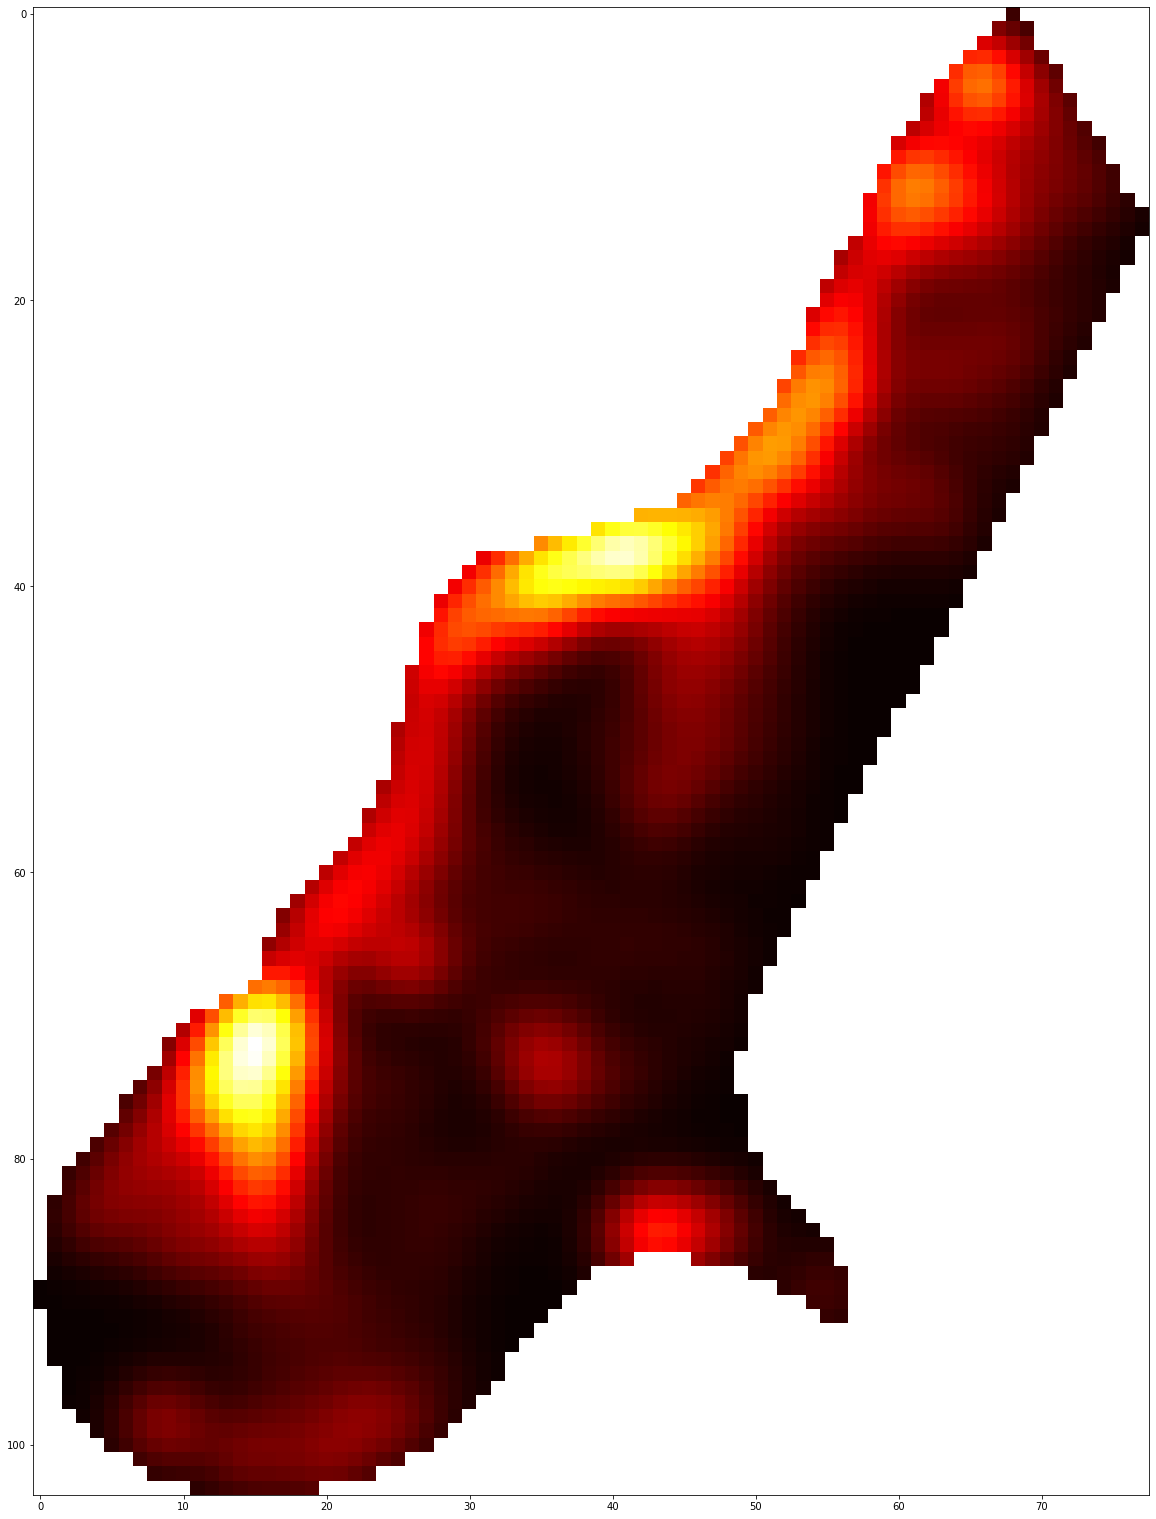

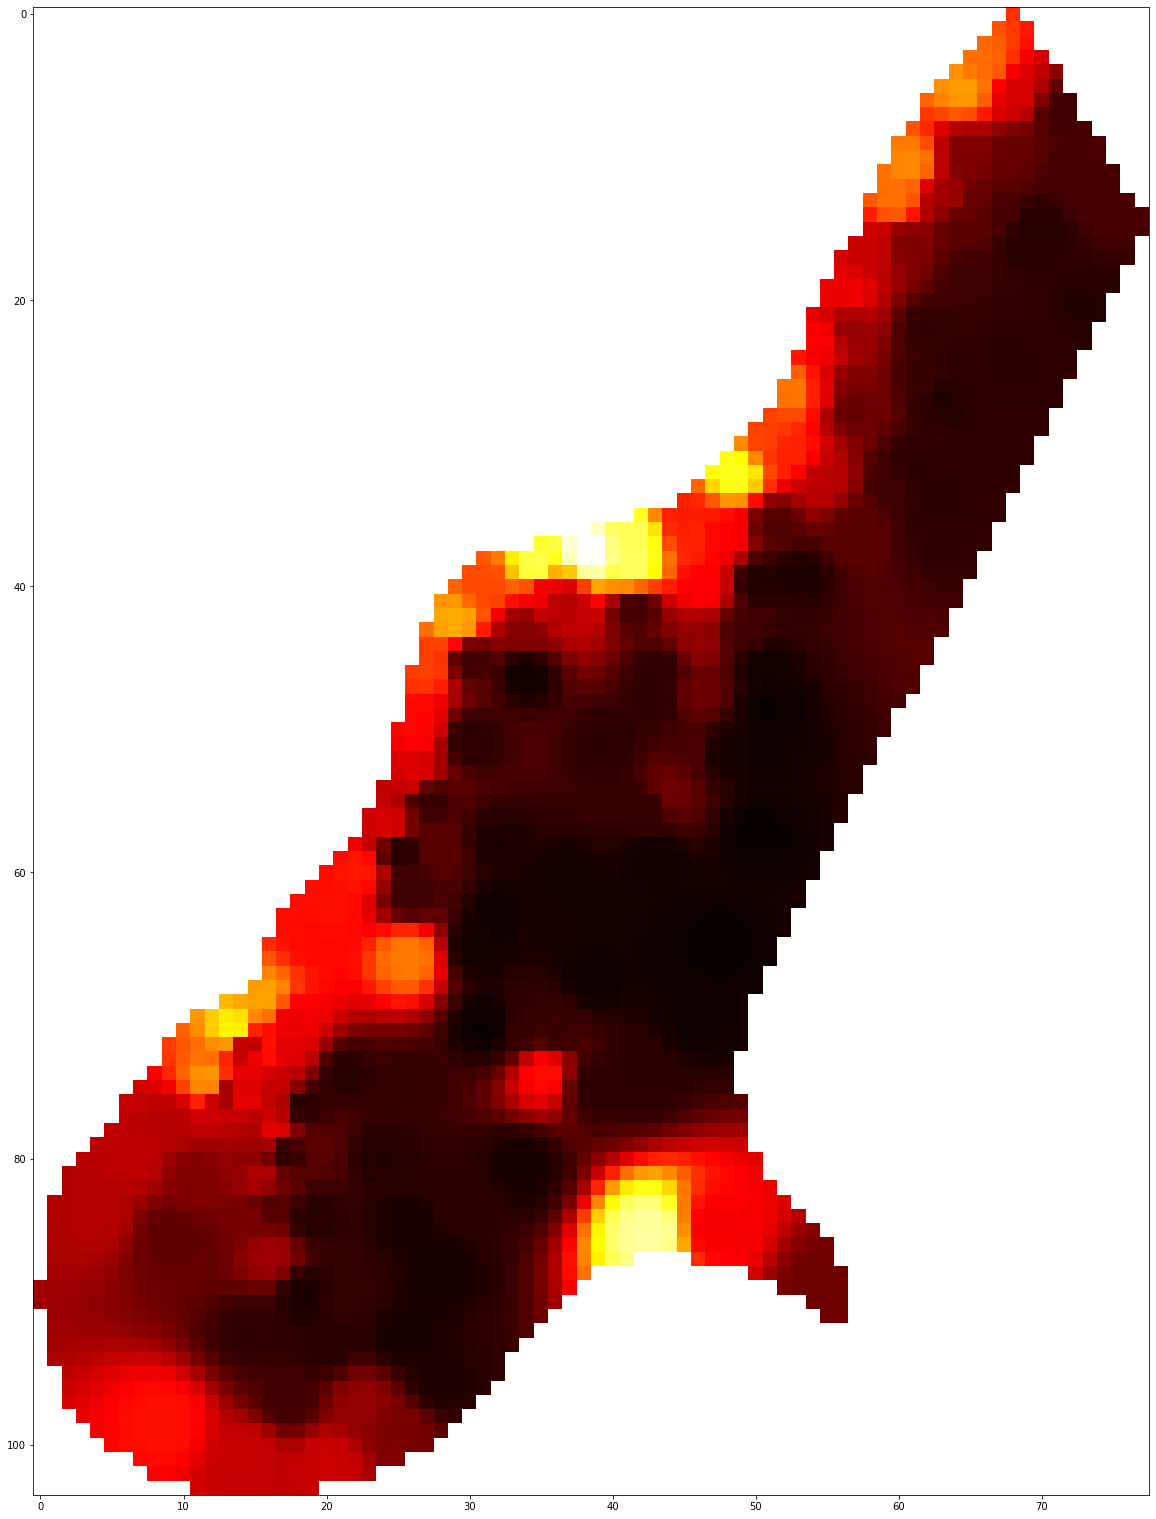

In [6]:
# Iterate through the ones array and consider just the values which are not no_data
for y in range(mask_array.shape[0]):
    for x in range(mask_array.shape[1]):
        
        if mask_array[y][x] != no_data:
            kde_array[y][x] = kde((x, y))
            idw_array[y][x] = idw((x, y))
        
        else:
            kde_array[y][x] = -1
            idw_array[y][x] = -1
         
masked_values = np.where(kde_array == -1, 1, 0)
masked_kde_array = ma.array(kde_array, mask=masked_values)
show_raster_map(masked_kde_array)
masked_idw_array = ma.array(idw_array, mask=masked_values)
show_raster_map(masked_idw_array)